# Prediction of Dynamic Variables in Sznajd Model

## Imports

In [80]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

CONSENSUS_TIME = 'consensus_time'
OPINION_CHANGE_FREQUENCY = 'opinion_change_frequency'

FEATURES = [
    'clustering', 'closeness', 'betweenness',
    'average_shortest_path_lenght', 'eigenvector', 'assortativity',
    'information_centrality',
    'approximate_current_flow_betweenness_centrality', 'shannon_entropy',
    'degree_variance'
]

UNCORRELATED_FEATURE_SUBSET = [
    'clustering', 
    'closeness',
    'assortativity',
    'shannon_entropy'
]

In [11]:
dataset = pd.read_csv('../data/dataset.csv')

## Training and prediction

In [19]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, GroupKFold, StratifiedGroupKFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PoissonRegressor, TweedieRegressor, LinearRegression
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
import optuna

In [58]:
p = 1
from sklearn.metrics import r2_score

def adjusted_r2_score(y: np.array, y_hat: np.array):
    """
    Computes R² score. It decreases if many variables are introduced.
    n: number of observations in sample 
    p: number of independent variables
    """
    n = len(y_hat)
    return 1 - ((1 - r2_score(y, y_hat)) * ((n - 1)/(n - p - 1)))

## Opinion Change Frequency
considering only random initialization

In [8]:
filtered_dataset = dataset[dataset['initialization'] == 'random']
X = filtered_dataset[FEATURES]
y = filtered_dataset[OPINION_CHANGE_FREQUENCY]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [14]:
y_train = np.array(y_train).reshape(-1, 1)

### Scaler

In [15]:
feature_scaler = StandardScaler()
feature_scaler.fit(X_train[FEATURES])
X_train[FEATURES] = feature_scaler.transform(X_train[FEATURES])

In [16]:
target_scaler = StandardScaler()
target_scaler.fit(y_train)
y_train = target_scaler.transform(y_train)

### Optuna Objective Class

In [17]:
class PoissonRegressionObjective:
    def __init__(self, X, y, cross_validation):
        self.X = X
        self.y = y
        self.cross_validation = cross_validation
        
    def __call__(self, trial):
        parameters = {
            'max_iter': 10000,
            'alpha': trial.suggest_float('alpha', 0, 1)
        }

        regressor = PoissonRegressor(**parameters)
        score_list = []
        splits = self.cross_validation.split(
            self.X, 
            y=self.y
        )

        for train_index, val_index in splits:
            _X_train, _X_val = self.X.iloc[train_index], self.X.iloc[val_index]
            _y_train, _y_val = self.y.iloc[train_index], self.y.iloc[val_index]

            model = clone(regressor)

            model.fit(_X_train, _y_train)
            y_val_pred = model.predict(_X_val)
            score = r2_score(_y_val, y_val_pred)
            score_list.append(score)

        return np.mean(score_list)

In [18]:
class RandomForestObjective:
    def __init__(self, X, y, cross_validation):
        self.X = X
        self.y = y
        self.cross_validation = cross_validation
        
    def __call__(self, trial):
        parameters = {
            'random_state': 1,
            'max_depth': trial.suggest_int('max_depth', 2, 50),
            'max_features': trial.suggest_int('max_features', 2, 4),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10, step=2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        }

        rf_regressor = RandomForestRegressor(**parameters)
        score_list = []
        splits = self.cross_validation.split(
            self.X, 
            y=self.y
        )

        for train_index, val_index in splits:
            _X_train, _X_val = self.X.iloc[train_index], self.X.iloc[val_index]
            _y_train, _y_val = self.y.iloc[train_index], self.y.iloc[val_index]

            model = clone(rf_regressor)

            model.fit(_X_train, _y_train)
            y_val_pred = model.predict(_X_val)
            score = r2_score(_y_val, y_val_pred)
            score_list.append(score)

        return np.mean(score_list)

In [112]:
study = optuna.create_study()

study.optimize(
    PoissonRegressionObjective(
        X_train, 
        y_train, 
        KFold(n_splits=5, shuffle=True, random_state=0)
    ), 
    n_trials=100,
)

best_score = study.best_value
best_params = study.best_params
print('--> R2=%.3f, Param=%s' % (best_score, best_params))

[I 2024-08-14 13:30:27,690] A new study created in memory with name: no-name-feaa586d-5fde-4198-a399-c96b6df43534


[I 2024-08-14 13:30:27,838] Trial 0 finished with value: 0.9654132035713602 and parameters: {'alpha': 0.14282420250353534}. Best is trial 0 with value: 0.9654132035713602.
[I 2024-08-14 13:30:27,974] Trial 1 finished with value: 0.9656221585455264 and parameters: {'alpha': 0.8042334353062295}. Best is trial 0 with value: 0.9654132035713602.
[I 2024-08-14 13:30:28,115] Trial 2 finished with value: 0.9655444095909613 and parameters: {'alpha': 0.5256147123345678}. Best is trial 0 with value: 0.9654132035713602.
[I 2024-08-14 13:30:28,262] Trial 3 finished with value: 0.9654739667027114 and parameters: {'alpha': 0.30503922279764983}. Best is trial 0 with value: 0.9654132035713602.
[I 2024-08-14 13:30:28,395] Trial 4 finished with value: 0.9656087971743613 and parameters: {'alpha': 0.7534921288324891}. Best is trial 0 with value: 0.9654132035713602.
[I 2024-08-14 13:30:28,535] Trial 5 finished with value: 0.965436299022444 and parameters: {'alpha': 0.2003942693158065}. Best is trial 0 with 

--> R2=0.965, Param={'alpha': 0.0005080656089359002}


In [20]:
X_train = sm.add_constant(X_train)
X_train

,const,clustering,closeness,average_shortest_path_lenght,eigenvector,assortativity,information_centrality,approximate_current_flow_betweenness_centrality,shannon_entropy,degree_variance
1536,1.0,2.078949,-1.723138,1.737579,1.541417,0.098281,-1.810097,1.948557,-1.930707,-0.616677
834,1.0,-0.533811,0.079612,-0.362231,0.759489,0.150782,1.166064,-0.410746,0.582013,-0.562884
1341,1.0,-0.464473,0.131408,-0.380927,-0.759509,1.201323,0.536262,-0.417453,0.714608,-0.440771
486,1.0,-0.475077,1.529464,-0.809938,-1.004048,-1.965067,-0.267848,-0.672513,-0.310941,2.454561
1665,1.0,2.069035,-1.741450,1.788772,0.683024,0.108861,-1.778535,1.886836,-1.882446,-0.616677
...,...,...,...,...,...,...,...,...,...,...
210,1.0,-0.447694,0.307667,-0.454964,-0.889000,0.055241,0.305941,-0.454626,0.564096,-0.147797
831,1.0,-0.528423,0.059899,-0.352608,0.977930,0.158273,0.998971,-0.416881,0.648631,-0.572658
27,1.0,-0.439589,0.324816,-0.461654,-0.948034,0.002651,0.300070,-0.450144,0.560261,-0.040380
1077,1.0,-0.466179,0.128394,-0.379335,-0.790401,1.207618,0.546675,-0.402592,0.715357,-0.421237


### Ploting Feature Importance

Text(0.5, 1.0, 'Feature Importance Opinion Change Frequency')

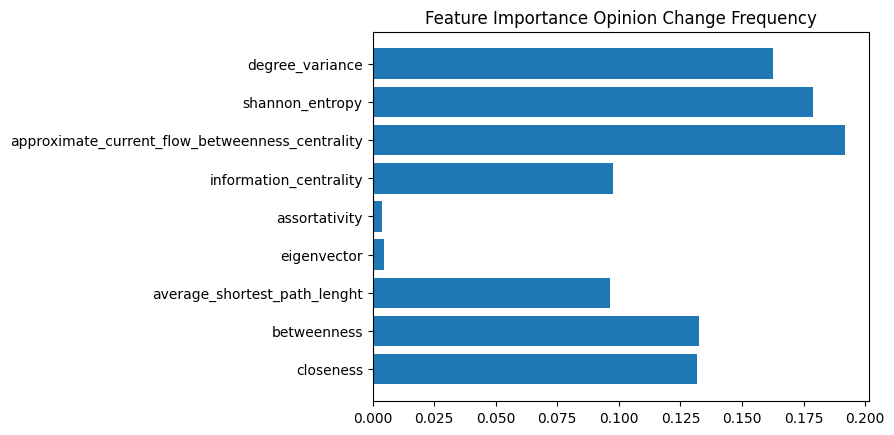

In [71]:
model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)
fig, ax = plt.subplots()
ax.barh(FEATURES, model.feature_importances_)
ax.set_title(f'Feature Importance Opinion Change Frequency')

### Testing

Text(0.5, 1.0, 'Opinion Change Frequency')

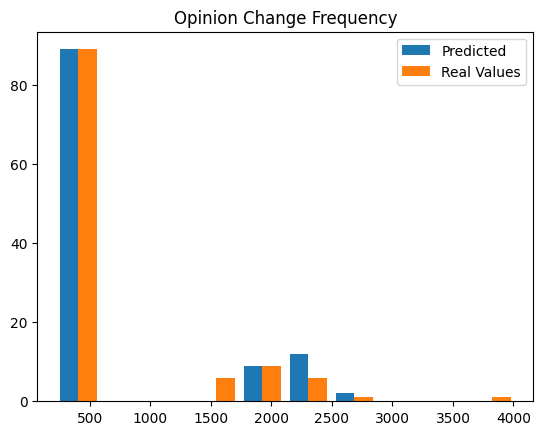

In [98]:
plt.hist([y_test_pred, y_test])
plt.legend(['Predicted', 'Real Values'])
plt.title('Opinion Change Frequency')

## Consensus Time

In [25]:
dataset['groups'] = LabelEncoder().fit_transform(dataset['type'])

In [25]:
X = dataset[UNCORRELATED_FEATURE_SUBSET]
y = np.log1p(dataset[CONSENSUS_TIME])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

## Linear Regression CV

In [65]:
def LinearRegressionCV(X, y):
    cross_validation = KFold(n_splits=10)

    splits = cross_validation.split(
        X, 
        y=y
    )

    score_list = []
    feature_list = []
    
    regressor = LinearRegression()
    feature_selector = SequentialFeatureSelector(
        regressor,
        tol=0.01,
        direction='forward'
    )
    
    for train_index, val_index in splits:
        _X_train, _X_val = X.iloc[train_index], X.iloc[val_index]
        _y_train, _y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Feature selection
        sfs = clone(feature_selector) 
        sfs.fit(_X_train, _y_train)
        selected_subset = np.array(UNCORRELATED_FEATURE_SUBSET)[sfs.get_support()]
        p = len(selected_subset)

        # Evaluation
        model = clone(regressor)
        model.fit(_X_train[selected_subset], _y_train)
        y_val_pred = model.predict(_X_val[selected_subset])
        
        score = adjusted_r2_score(_y_val, y_val_pred)
        score_list.append(score)

        for selected_feature in selected_subset:
            feature_list.append(selected_feature)

        print(f'R2: {score} w/ {selected_subset}')

In [66]:
LinearRegressionCV(X_train, y_train)

R2: 0.9483181622548431 w/ ['clustering' 'closeness']
R2: 0.9520454174352564 w/ ['clustering' 'closeness']
R2: 0.9580033944486813 w/ ['clustering' 'closeness']
R2: 0.9404944211207396 w/ ['clustering' 'closeness']
R2: 0.9496774157768243 w/ ['clustering' 'closeness']
R2: 0.9511962791827738 w/ ['clustering' 'closeness']
R2: 0.9474724004326239 w/ ['clustering' 'closeness']
R2: 0.9498739575332497 w/ ['clustering' 'closeness']
R2: 0.9511875674083954 w/ ['clustering' 'closeness']
R2: 0.9474391792363432 w/ ['clustering' 'closeness']


In [71]:
SELECTED_SUBSET = ['clustering', 'closeness']

In [72]:
mod = sm.OLS(
    endog=y_train, 
    exog=sm.add_constant(X_train[SELECTED_SUBSET]),
)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         consensus_time   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 1.285e+04
Date:                Fri, 23 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:37:10   Log-Likelihood:                -763.40
No. Observations:                1339   AIC:                             1533.
Df Residuals:                    1336   BIC:                             1548.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8050      0.080    134.503      0.0

In [75]:
y_pred = res.predict(sm.add_constant(X_test[SELECTED_SUBSET]))

In [87]:
p = 2
adjusted_r2_score(y_pred, y_test)

0.9442602095440522

Text(0.5, 1.0, 'Consensus Time')

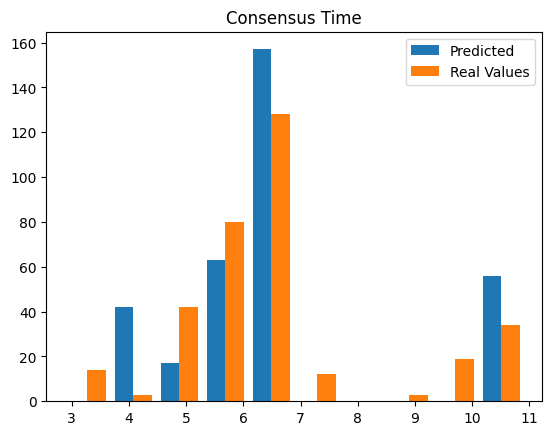

In [79]:
plt.hist([y_pred, y_test])
plt.legend(['Predicted', 'Real Values'])
plt.title('Consensus Time')

Text(0.5, 0, 'Clustering')

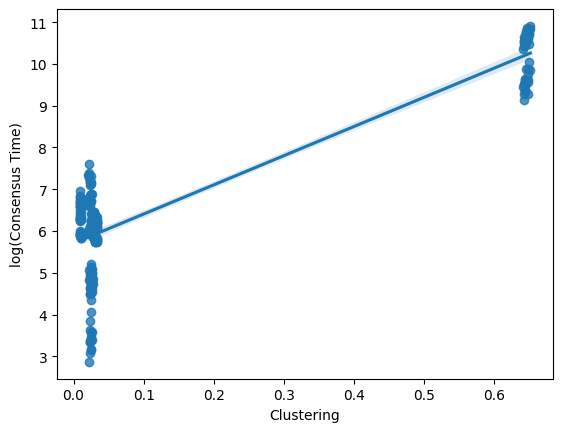

In [83]:
ax = sns.regplot(y=y_test, x=X_test['clustering'])
ax.set_ylabel('log(Consensus Time)')
ax.set_xlabel('Clustering')

Text(0.5, 0, 'Closeness')

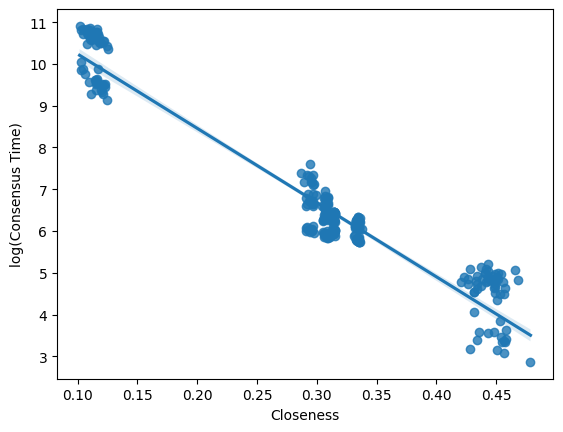

In [82]:
ax = sns.regplot(y=y_test, x=X_test['closeness'])
ax.set_ylabel('log(Consensus Time)')
ax.set_xlabel('Closeness')

### Ploting Feature Importance

Text(0.5, 1.0, 'Feature Importance Consensus Time')

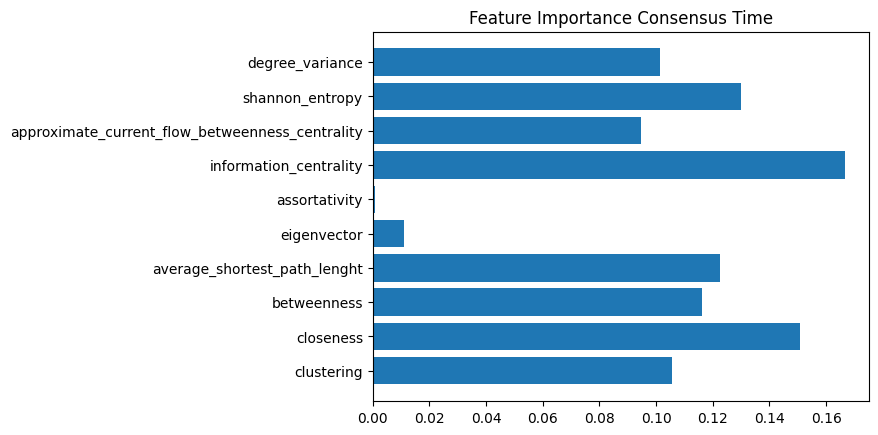

In [32]:
model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)
fig, ax = plt.subplots()
ax.barh(FEATURES, model.feature_importances_)
ax.set_title(f'Feature Importance Consensus Time')

### Testing

In [57]:
y_test_pred = model.predict(X_test)
score = r2_score(y_test, y_test_pred)
print(f'R2 Score on test: {score}')

R2 Score on test: 0.9883839810480076
